In [21]:
import numpy as np
from dotenv import load_dotenv
from dwave.system import DWaveSampler, EmbeddingComposite
from numpy import hamming
from openjij import SQASampler
import openjij
from pyqubo import Array, Constraint, LogEncInteger, solve_qubo
import math
import os
import dimod
from minorminer import find_embedding
from dwave.system import FixedEmbeddingComposite
from dwave.embedding import embed_bqm
from dwave.embedding import MinimizeEnergy
from matplotlib import pyplot as plt
import sklearn
import itertools
from copy import copy, deepcopy

In [22]:
load_dotenv()

TOKEN = os.getenv("TOKEN")
endpoint = "https://cloud.dwavesys.com/sapi/"

In [23]:
W = 50
cost_list = [70,
             20,
             39,
             37,
             7,
             5,
             10, ]
weight_list = [31,
               10,
               20,
               19,
               4,
               3,
               6, ]
opt = [1,
0,
0,
1,
0,
0,
0]
N = len(cost_list)

In [24]:
x = Array.create('x', shape=(N), vartype='BINARY')
y = LogEncInteger("y", (0, W))

In [25]:
# key1 = max(cost_list, key=lambda k: cost_list[k])
max_c = max(cost_list)
B = 1
A = B * max_c + 1

In [26]:
HA = Constraint(
    A * (W - sum(weight_list[a] * x[a] for a in range(N)) - y)**2, label='HA'
)

HB = - B * sum(cost_list[a] * x[a] for a in range(N))

In [27]:
H = HA + HB
model = H.compile()
Q, offset = model.to_qubo()

In [28]:
dw_sampler = DWaveSampler(solver='DW_2000Q_6',
                          token=TOKEN, endpoint=endpoint)
adj = {}
for k in Q.keys():
    adj[k] = 1
embedding = find_embedding(adj, dw_sampler.edgelist)
# bqm_embed = embed_bqm(bqm, embedding, dw_sampler.adjacency)
sampler = FixedEmbeddingComposite(dw_sampler, embedding)
# sampler = EmbeddingComposite(dw_sampler)
# sampleset_embed = dw_sampler.sample(bqm_embed, num_reads=10)

In [29]:
t = [(0, 20), (0, 10, 20), (0, 5, 15, 20), (0, 10, 20)]
s = [(0, 1), (0, 0, 1), (0, 0.5, 0.5, 1), (0, 1, 1)]

schedules = [list(zip(t[i], s[i])) for i in range(len(t))]
print(schedules)

[[(0, 0), (20, 1)], [(0, 0), (10, 0), (20, 1)], [(0, 0), (5, 0.5), (15, 0.5), (20, 1)], [(0, 0), (10, 1), (20, 1)]]


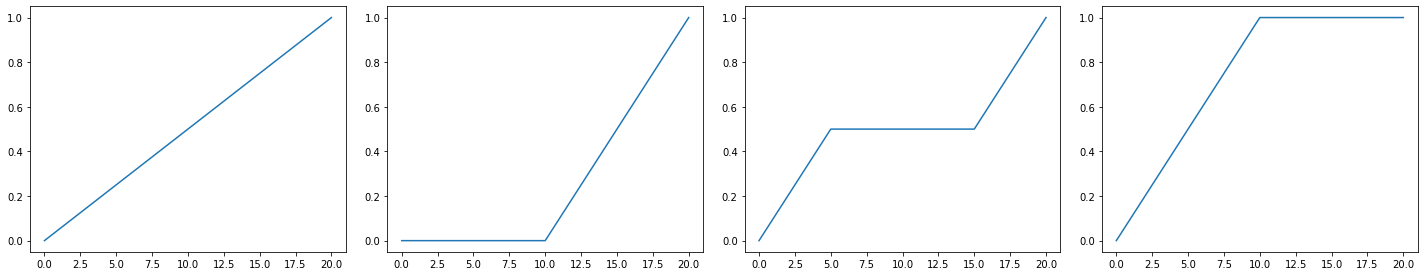

In [30]:
fig, ax = plt.subplots(1, len(schedules))
fig.set_figwidth(20)
plt.tight_layout()
for i in range(len(t)):
    ax[i].plot(t[i], s[i])

plt.savefig("output.jpg")

In [32]:
samplesets = []
for schedule in schedules:
    print("annealing start")
    samplesets.append(sampler.sample_qubo(
        Q, num_reads=1000, anneal_schedule=schedule))
    print("annealing end")

annealing start
annealing end
annealing start
annealing end
annealing start
annealing end
annealing start
annealing end


In [33]:
def transform_sample(sampleset, model):
    decoded_sample = model.decode_sample(
        sampleset.first.sample, vartype="BINARY")

    cost = 0
    weight = 0
    for k in range(N):
        if decoded_sample.array('x', k) != 0:
            cost += cost_list[k]
            weight += weight_list[k]

    sol_y = sum(2**k * v for k, v in [(elem, decoded_sample.array('y', elem))
                                      for elem in range(math.ceil(math.log2(W)))])

    return {"slack_y": sol_y, "broken": deepcopy(decoded_sample.constraints(only_broken=True)), "cost": cost, "weight": weight}

def v_transform_sample(samplesets, model):
    if type(samplesets) == list:
        sample_info = []
        for sampleset in samplesets:
            sample_info.append(transform_sample(sampleset, model))
        return sample_info
    else:
        return transform_sample(transform_sample(samplesets, model))

In [34]:
def output_sample_info(sample_info):
    print("slack_Y = {}".format(sample_info["slack_y"]))
    print("broken: {}".format(sample_info["broken"]))
    print("cost : "+str(sample_info["cost"]))
    print("weight : "+str(sample_info["weight"]))
    print()

def v_output_sample_info(samples_info):
    if type(samples_info) == list:
        for sample_info in samples_info:
            output_sample_info(sample_info)
    else:
        output_sample_info(samples_info)

In [35]:
sample_info = v_transform_sample(samplesets, model)
v_output_sample_info(sample_info)

slack_Y = 571
broken: {'HA': (False, 241.0)}
cost : 877
weight : 453

slack_Y = 75
broken: {'HA': (False, 87001.0)}
cost : 1325
weight : 694

slack_Y = 666
broken: {'HA': (False, 964.0)}
cost : 685
weight : 355

slack_Y = 8
broken: {'HA': (False, 964.0)}
cost : 1430
weight : 744



## リバースアニーリング

In [ ]:
init = samplesets[0].samples()[-1]

In [ ]:
t = (0, 5, 20)
s = (1.0, 0.4, 1.0)

schedule = list(zip(t, s))

In [ ]:
plt.plot(t,s)
plt.show()

In [ ]:
sampleset = sampler.sample_qubo(
    Q, num_reads=30, anneal_schedule=schedule, initial_state=init)

In [ ]:
sampleset.record

In [ ]:
sample_info = transform_sample(sampleset)
output_sample_info(sample_info)